In [1]:
# 语言分割和数据集

%matplotlib inline
import os
import torch
import torchvision
from d2l import torch as d2l

In [2]:
#@save
d2l.DATA_HUB['voc2012'] = (d2l.DATA_URL + 'VOCtrainval_11-May-2012.tar',
                           '4e443f8a2eca6b1dac8a6c57641b67dd40621a49')
voc_dir = d2l.download_extract('voc2012', 'VOCdevkit/VOC2012')

In [3]:
# 将read_voc_images函数定义为将所有输⼊的图像和标签读⼊内存

#@save
def read_voc_images(voc_dir, is_train=True): # voc_dir 数据集所在目录
    """读取所有VOC图像并标注"""
    # 添加数据集中的 train.txt 文件
    txt_fname = os.path.join(voc_dir, 'ImageSets', 'Segmentation',
                             'train.txt' if is_train else 'val.txt')
    mode = torchvision.io.image.ImageReadMode.RGB # 图像读取模式
    with open(txt_fname, 'r') as f:
        images = f.read().split() # 读取txt文件并通过split()函数分为单独的string
    features, labels = [], [] # 特征 标签
    for i, fname in enumerate(images):
        features.append(torchvision.io.read_image(os.path.join(
            voc_dir, 'JPEGImages', f'{fname}.jpg'))) # 添加特征图片
        labels.append(torchvision.io.read_image(os.path.join(
            voc_dir, 'SegmentationClass' ,f'{fname}.png'), mode)) # 添加标签图片 
    return features, labels
train_features, train_labels = read_voc_images(voc_dir, True) # 调用

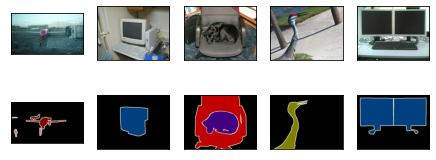

In [4]:
# 下⾯我们绘制前5个输⼊图像及其标签
'在标签图像中，⽩⾊和⿊⾊分别表⽰边框和背景，⽽其他颜⾊则对应不同的类别'

n = 5
imgs = train_features[0:n] + train_labels[0:n] # 读取图像的特征与标签
imgs = [img.permute(1,2,0) for img in imgs] # 变换 C H W 
d2l.show_images(imgs, 2, n);

In [5]:
# 接下来，我们列举RGB颜⾊值和类名
#@save
VOC_COLORMAP = [[0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0],
                [0, 0, 128], [128, 0, 128], [0, 128, 128], [128, 128, 128],
                [64, 0, 0], [192, 0, 0], [64, 128, 0], [192, 128, 0],
                [64, 0, 128], [192, 0, 128], [64, 128, 128], [192, 128, 128],
                [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0],
                [0, 64, 128]]
#@save
VOC_CLASSES = ['background', 'aeroplane', 'bicycle', 'bird', 'boat',
                'bottle', 'bus', 'car', 'cat', 'chair', 'cow',
                'diningtable', 'dog', 'horse', 'motorbike', 'person',
                'potted plant', 'sheep', 'sofa', 'train', 'tv/monitor']

In [8]:
# 定义 voc_colormap2label 函数来构建从上述RGB颜⾊值到类别索引的映射
#@save
def voc_colormap2label():
    """构建从RGB到VOC类别索引的映射"""
    colormap2label = torch.zeros(256 ** 3, dtype=torch.long) # 变量初始化
    for i, colormap in enumerate(VOC_COLORMAP):
        colormap2label[
            (colormap[0] * 256 + colormap[1]) * 256 + colormap[2]] = i
    return colormap2label
# 定义 voc_label_indices 函数将RGB值映射到在Pascal VOC2012数据集中的类别索引
#@save
def voc_label_indices(colormap, colormap2label):
    """将VOC标签中的RGB值映射到它们的类别索引"""
    colormap = colormap.permute(1, 2, 0).numpy().astype('int32')
    idx = ((colormap[:, :, 0] * 256 + colormap[:, :, 1]) * 256 
           + colormap[:, :, 2])
    return colormap2label[idx]


In [9]:
# 例如，在第⼀张样本图像中，⻜机头部区域的类别索引为1，⽽背景索引为0
y = voc_label_indices(train_labels[0], voc_colormap2label())
y[105:115, 130:140], VOC_CLASSES[1]

(tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
         [0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
         [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 0, 0, 0, 1, 1]]),
 'aeroplane')

In [10]:
# 预处理数据
''' 
在之前的实验，例如 7.1节—7.4节中，我们通过再缩放图像使其符合模型的输⼊形状。然⽽在语义分割中，这
样做需要将预测的像素类别重新映射回原始尺⼨的输⼊图像。这样的映射可能不够精确，尤其在不同语义的
分割区域。为了避免这个问题，我们将图像裁剪为固定尺⼨，⽽不是再缩放。具体来说，我们使⽤图像增⼴
中的随机裁剪，裁剪输⼊图像和标签的相同区域
'''
#@save
def voc_rand_crop(feature, label, height, width):
    """随机裁剪特征和标签图像"""
    rect = torchvision.transforms.RandomCrop.get_params(feature, (height, width))
    feature = torchvision.transforms.functional.crop(feature, *rect)
    label = torchvision.transforms.functional.crop(label, *rect)
    return feature, label


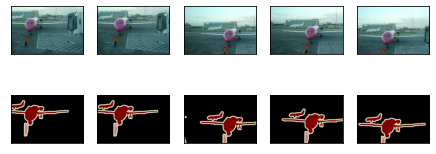

In [11]:
imgs = []
for _ in range(n):
    imgs += voc_rand_crop(train_features[0], train_labels[0], 200, 300)
imgs = [img.permute(1, 2, 0) for img in imgs]
d2l.show_images(imgs[::2] + imgs[1::2], 2, n);

In [12]:
# ⾃定义语义分割数据集类
''' 
我们通过继承⾼级API提供的Dataset类，⾃定义了⼀个语义分割数据集类VOCSegDataset。通过实
现__getitem__函数，我们可以任意访问数据集中索引为idx的输⼊图像及其每个像素的类别索引。由于数
据集中有些图像的尺⼨可能⼩于随机裁剪所指定的输出尺⼨，这些样本可以通过⾃定义的filter函数移除
掉。此外，我们还定义了normalize_image函数，从⽽对输⼊图像的RGB三个通道的值分别做标准化
'''
#@save
class VOCSegDataset(torch.utils.data.Dataset):
    """⼀个⽤于加载VOC数据集的⾃定义数据集"""
    def __init__(self, is_train, crop_size, voc_dir):
        self.transform = torchvision.transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        self.crop_size = crop_size
        features, labels = read_voc_images(voc_dir, is_train=is_train)
        self.features = [self.normalize_image(feature) 
                         for feature in self.filter(features)]
        self.labels = self.filter(labels)
        self.colormap2label = voc_colormap2label()
        print('read ' + str(len(self.features)) + ' examples')
        
    def normalize_image(self, img): # 标准化
        return self.transform(img.float() / 255)
    
    def filter(self, imgs): # 过滤器
        return [img for img in imgs if (
            img.shape[1] >= self.crop_size[0] and 
            img.shape[2] >= self.crop_size[1])]
    
    def __getitem__(self, idx): # 访问数据集中索引为idx的输⼊图像及其每个像素的类别索引
        feature, label = voc_rand_crop(self.features[idx], self.labels[idx], 
                                       *self.crop_size)
        return (feature, voc_label_indices(label, self.colormap2label))

    def __len__(self):
        return len(self.features)


In [13]:
# 读取数据集
''' 
我们通过⾃定义的VOCSegDataset类来分别创建训练集和测试集的实例。假设我们指定随机裁剪的输出图
像的形状为320 × 480，下⾯我们可以查看训练集和测试集所保留的样本个数
'''
crop_size = (320, 480)
voc_train = VOCSegDataset(True, crop_size, voc_dir)
voc_test = VOCSegDataset(False, crop_size, voc_dir)


read 1114 examples
read 1078 examples


In [14]:
''' 
设批量⼤⼩为64，我们定义训练集的迭代器。打印第⼀个⼩批量的形状会发现：与图像分类或⽬标检测不同，
这⾥的标签是⼀个三维数组
'''
batch_size = 64
train_iter = torch.utils.data.DataLoader(voc_train, batch_size, shuffle=True, 
                                         drop_last=True, 
                                         num_workers=d2l.get_dataloader_workers())
for X, Y in train_iter:
    print(X.shape)
    print(Y.shape)
    break

torch.Size([64, 3, 320, 480])
torch.Size([64, 320, 480])


In [15]:
# 整合所有组件
''' 
最后，我们定义以下load_data_voc函数来下载并读取Pascal VOC2012语义分割数据集。它返回训练集和
测试集的数据迭代器
'''
#@save
def load_data_voc(batch_size, crop_size):
    """加载VOC语义分割数据集"""
    voc_dir = d2l.download_extract('voc2012', os.path.join('VOCdevkit', 'VOC2012'))
    num_workers = d2l.get_dataloader_workers()
    train_iter = torch.utils.data.DataLoader(
        VOCSegDataset(True, crop_size, voc_dir), batch_size,
        shuffle=True, drop_last=True, num_workers=num_workers)
    test_iter = torch.utils.data.DataLoader(
        VOCSegDataset(False, crop_size, voc_dir), batch_size,
        drop_last=True, num_workers=num_workers)
    return train_iter, test_iter

In [ ]:
''' 
⼩结
• 语义分割通过将图像划分为属于不同语义类别的区域，来识别并理解图像中像素级别的内容
• 语义分割的⼀个重要的数据集叫做 Pascal VOC2012
• 由于语义分割的输⼊图像和标签在像素上⼀⼀对应，输⼊图像会被随机裁剪为固定尺⼨⽽不是缩放
'''